# Introduction

This notebook uses the adult dataset to explore explainability methods. The adult dataset is data from the U.S. census, and the goal is to predict whether an indivbidual's income is greater than 50k dollars a year on the basis of:

age: continuous.

workclass: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked.

fnlwgt: continuous.

education: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool.

education-num: continuous.

marital-status: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse.

occupation: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces.

relationship: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried.

race: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black.

sex: Female, Male.

capital-gain: continuous.

capital-loss: continuous.

hours-per-week: continuous.

native-country: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

The data is from 1995, so it is outdated, but it's still an interesting case study as it presents a variety of variable types.

For this notebook, you will need the following libraries:
- scikit-learn, pandas, and numpy, and plotnine
- for PDP plots: sklearn
- for permutation importance: sklearn
- for ALE: alibi package
- for SHAP: the shap package (which is integrated in sklearn for tree-based models)
- for counterfactuals: dice-ml

install all packages with: `pip install pandas numpy plotnine scikit-learn alibi[all] shap dice-ml`

In [1]:
import pandas as pd
import numpy as np
from plotnine import *
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, recall_score, precision_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# The data

We load the data and perform the usual EDA and data cleaning. At this point in the course, you should be familiar with this procedure. Note that the data comes already split into fitting and test data. This is common procedure for datasets that are used for e.g. modelling competitions, so that each competitor model is evaluated on the same test set.

In [2]:
train = pd.read_csv("../dataset/adult/adult.data", header=None)
test = pd.read_csv("../dataset/adult/adult.test", header=None)

In [3]:
train
test

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K.
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K.
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K.
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K.
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16276,39,Private,215419,Bachelors,13,Divorced,Prof-specialty,Not-in-family,White,Female,0,0,36,United-States,<=50K.
16277,64,?,321403,HS-grad,9,Widowed,?,Other-relative,Black,Male,0,0,40,United-States,<=50K.
16278,38,Private,374983,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,50,United-States,<=50K.
16279,44,Private,83891,Bachelors,13,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455,0,40,United-States,<=50K.


In [3]:
# add proper headers to train and test, and since the test columns are in a different order, reorder them
colnames = [
    "age",
    "workclass",
    "fnlwgt",
    "education",
    "education-num",
    "marital-status",
    "occupation",
    "relationship",
    "race",
    "sex",
    "capital-gain",
    "capital-loss",
    "hours-per-week",
    "native-country",
    "target"
]
train.columns = colnames
test.columns = colnames

In [4]:
train
test

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,target
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,target
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K.
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K.
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K.
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K.
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16276,39,Private,215419,Bachelors,13,Divorced,Prof-specialty,Not-in-family,White,Female,0,0,36,United-States,<=50K.
16277,64,?,321403,HS-grad,9,Widowed,?,Other-relative,Black,Male,0,0,40,United-States,<=50K.
16278,38,Private,374983,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,50,United-States,<=50K.
16279,44,Private,83891,Bachelors,13,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455,0,40,United-States,<=50K.


In [4]:
# question marks: ?, should be missing values. Replace with nan
for i in train.columns:
    if train[i].dtype == "object":
        train[i] = train[i].str.strip(" ")
        test[i] = test[i].str.strip(" ")

train = train.replace('?', np.nan)
test = test.replace('?', np.nan)
test

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,target
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K.
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K.
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K.
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K.
4,18,NaN,103497,Some-college,10,Never-married,NaN,Own-child,White,Female,0,0,30,United-States,<=50K.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16276,39,Private,215419,Bachelors,13,Divorced,Prof-specialty,Not-in-family,White,Female,0,0,36,United-States,<=50K.
16277,64,NaN,321403,HS-grad,9,Widowed,NaN,Other-relative,Black,Male,0,0,40,United-States,<=50K.
16278,38,Private,374983,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,50,United-States,<=50K.
16279,44,Private,83891,Bachelors,13,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455,0,40,United-States,<=50K.


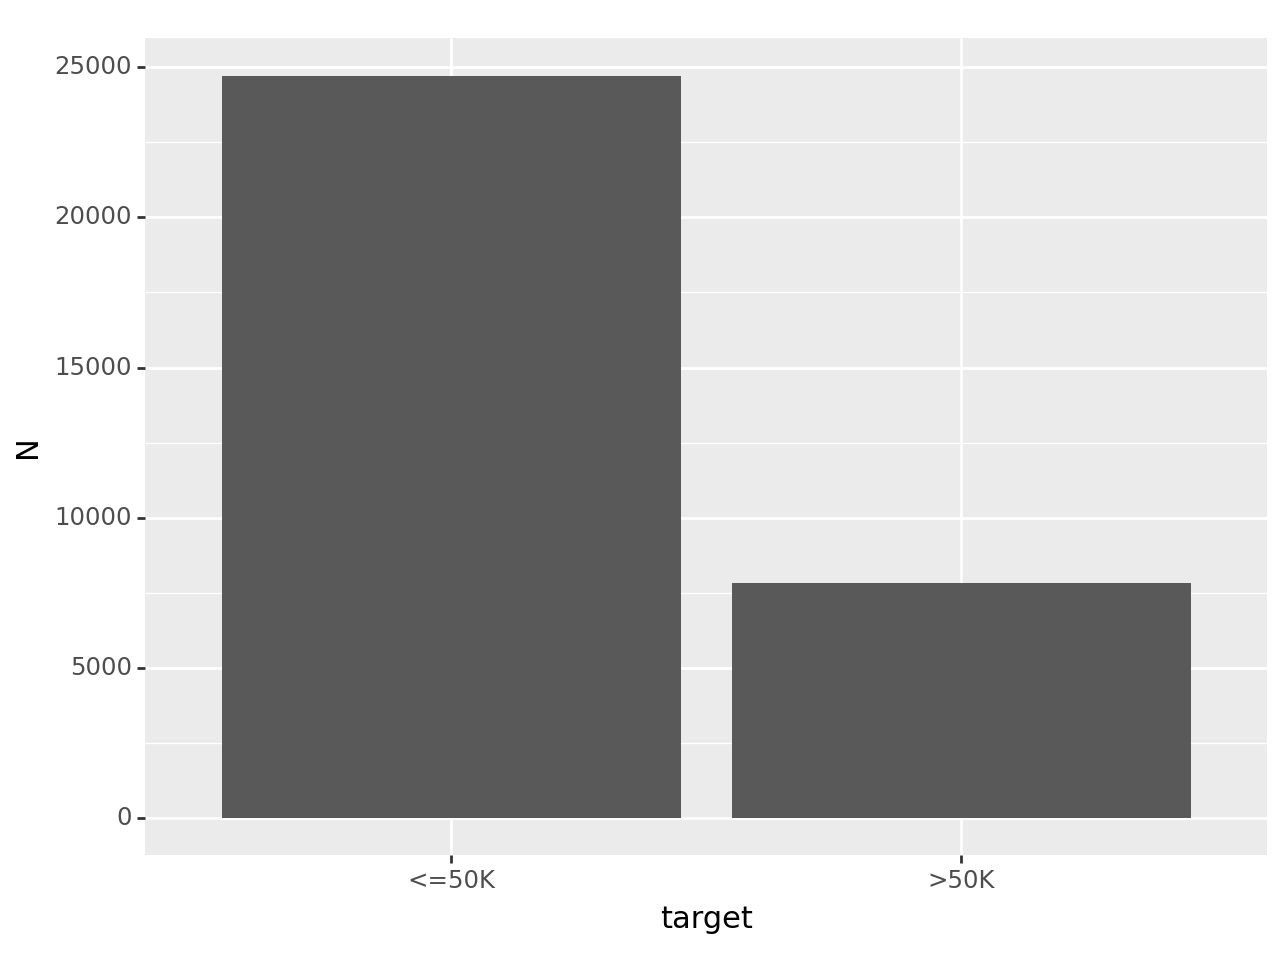

<Figure Size: (640 x 480)>

In [7]:
train_agg = train.groupby("target").size().reset_index().rename(columns={0: "N"})
ggplot(train_agg, aes(x="target", y="N")) + geom_bar(stat="identity")

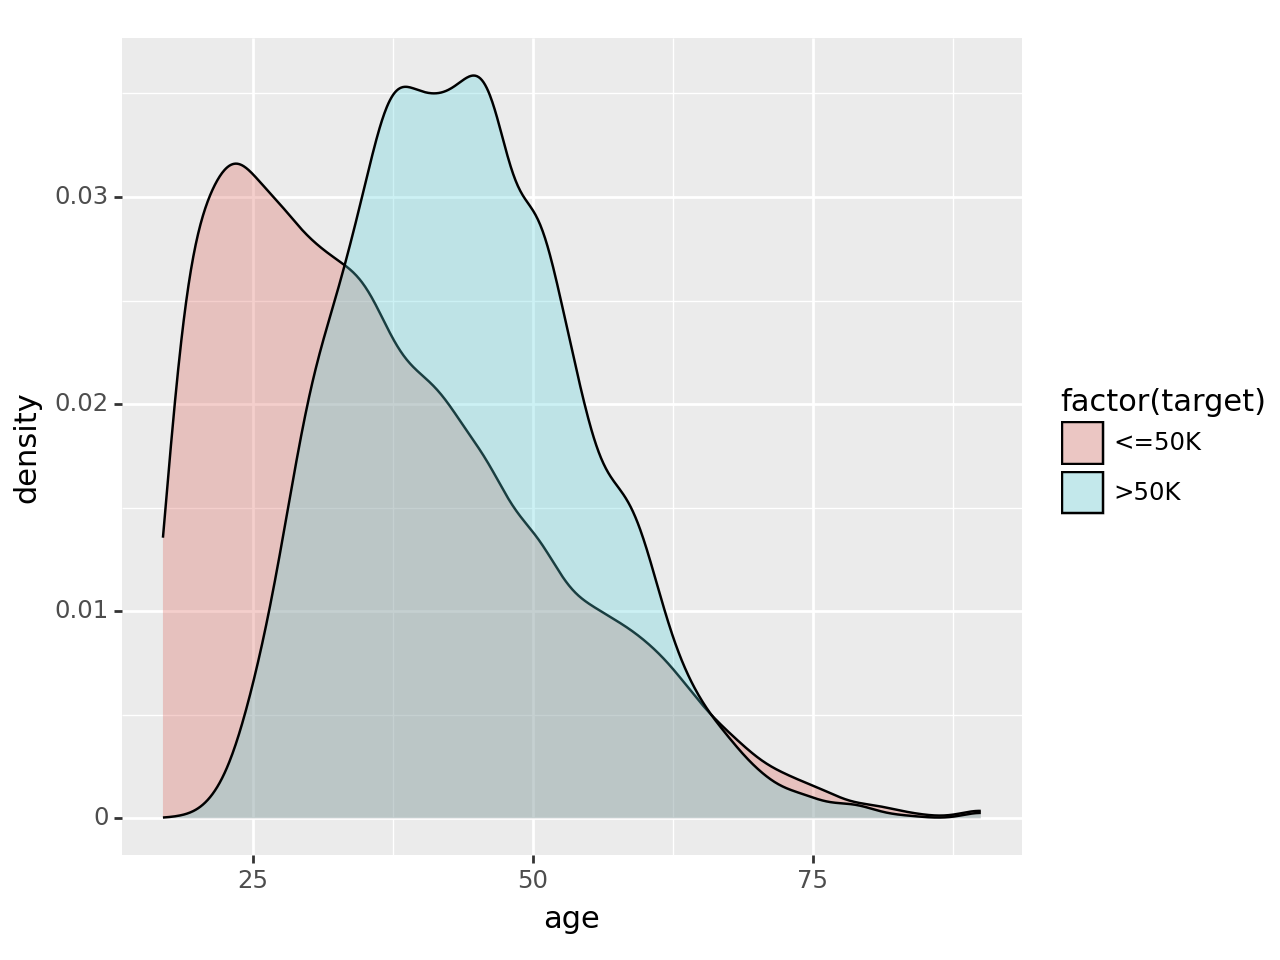

<Figure Size: (640 x 480)>

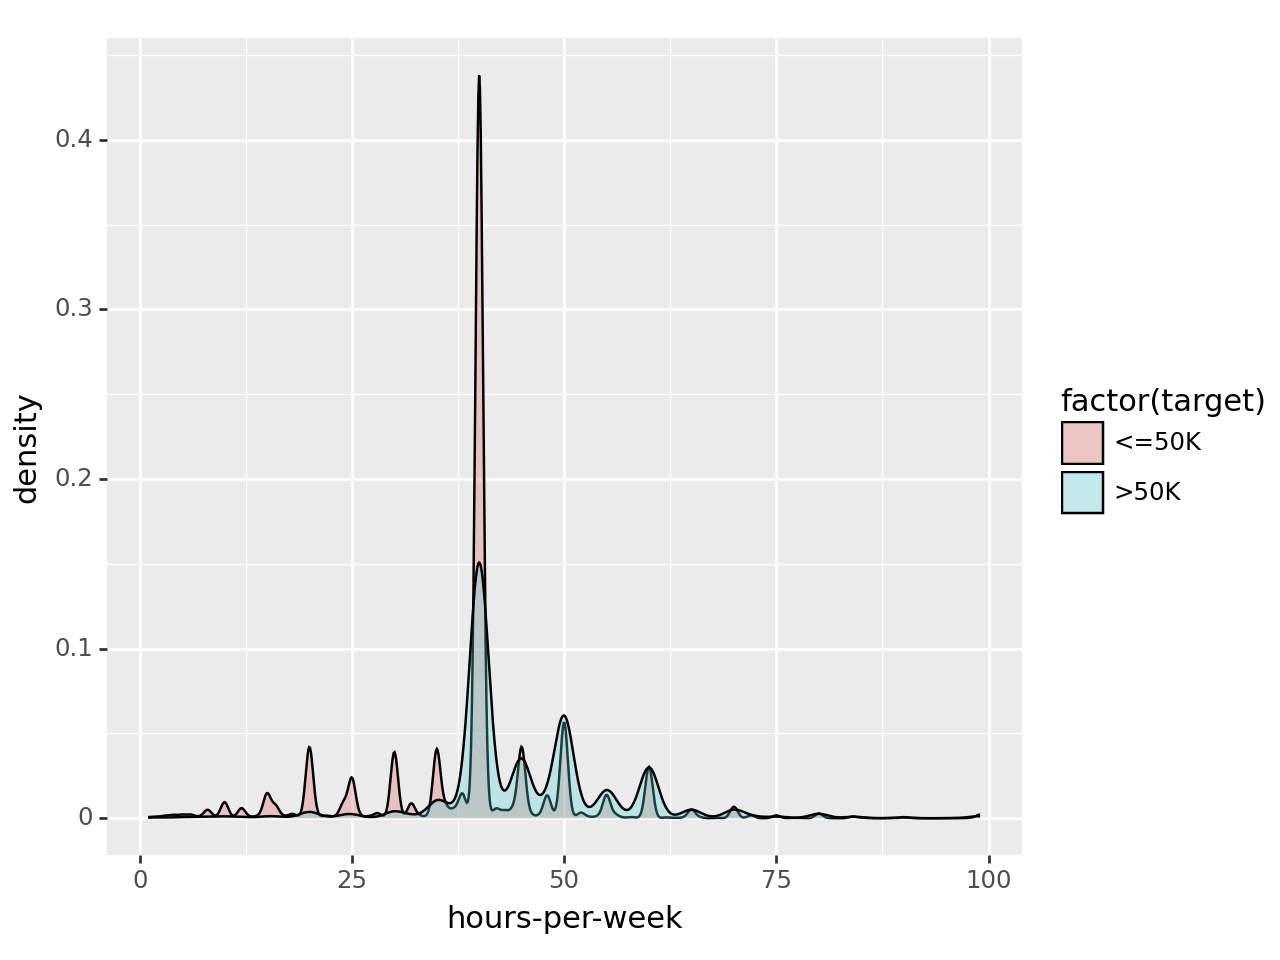

<Figure Size: (640 x 480)>

In [8]:
# age is obviously a good predictor here
(
    ggplot(train, aes(x='age', fill='factor(target)'))
    + geom_density(alpha=0.3)
)

# hours per week
(
    ggplot(train, aes(x='hours-per-week', fill='factor(target)'))
    + geom_density(alpha=0.3)
)

In [9]:
fulltime = train.assign(fulltime=np.where(
    train["hours-per-week"] < 40, 0, 1
))

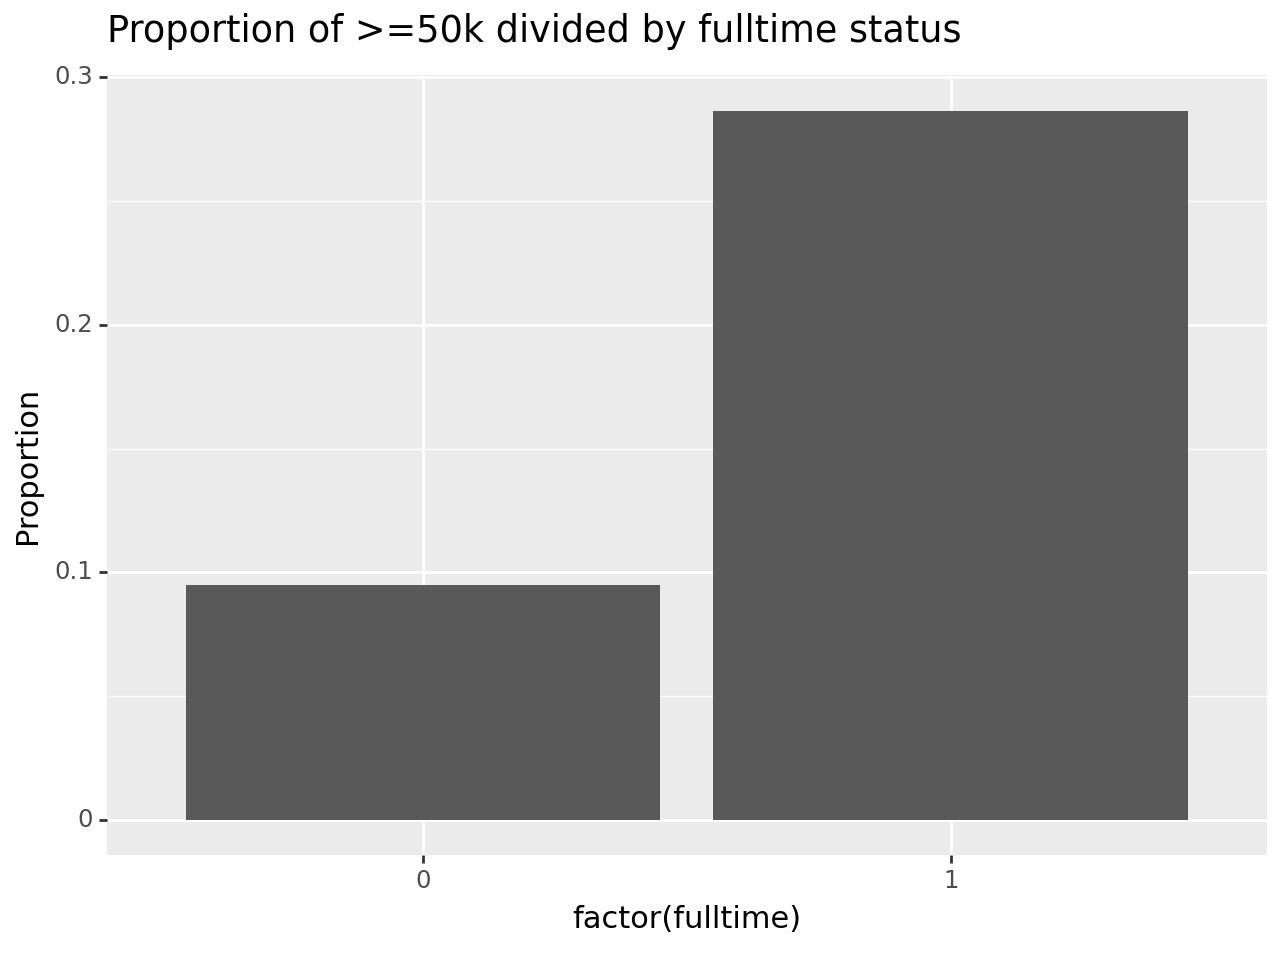

<Figure Size: (640 x 480)>

In [10]:
def calculate_freq_table(df, variables):
    var_series = [df[i] for i in variables]
    freq_table = pd.crosstab(var_series, train['target'])
    freq_table = freq_table.assign(N_obs = freq_table.sum(axis=1))
    freq_table = freq_table.assign(p = freq_table.iloc[:,1]/freq_table.N_obs)
    percentage_table = freq_table[['N_obs','p']]
    percentage_table.columns.name = None
    percentage_table = percentage_table.reset_index()
    return freq_table, percentage_table

(
    ggplot(
    calculate_freq_table(fulltime, ["fulltime"])[1], aes(x='factor(fulltime)', y='p')) + geom_bar(stat='identity', position='dodge')
    + labs(y='Proportion')
    + ggtitle("Proportion of >=50k divided by fulltime status")
)

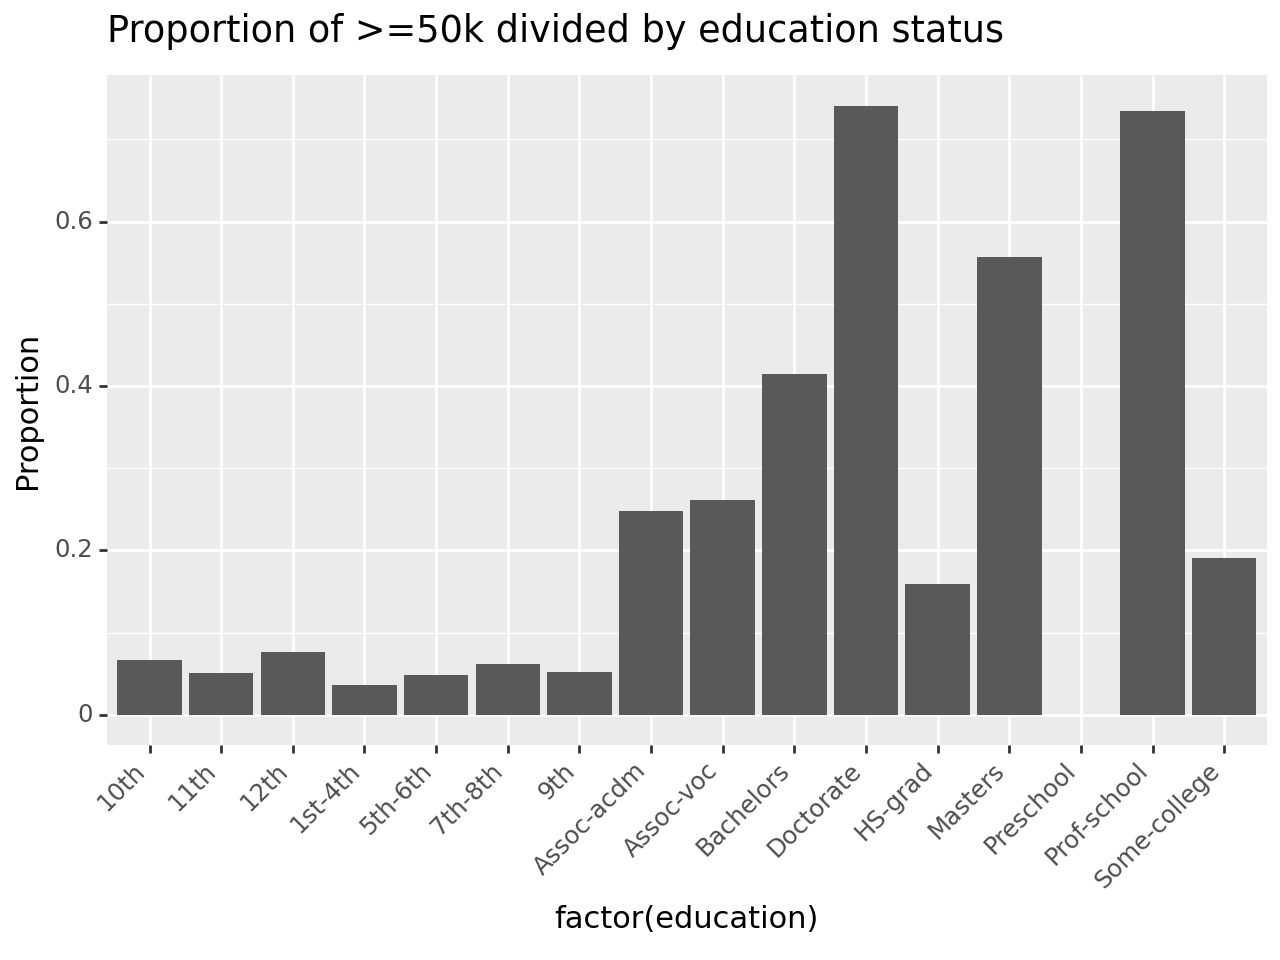

<Figure Size: (640 x 480)>

In [11]:
# education is also a great prediction
# note also that there are many levels of education in the dataset
# we might for instance decide to combine everything below 10th grade
(
    ggplot(
    calculate_freq_table(train, ["education"])[1], aes(x='factor(education)', y='p')) + geom_bar(stat='identity', position='dodge')
    + labs(y='Proportion')
    + ggtitle("Proportion of >=50k divided by education status")
    + theme(axis_text_x=element_text(rotation=45, hjust=1))
)

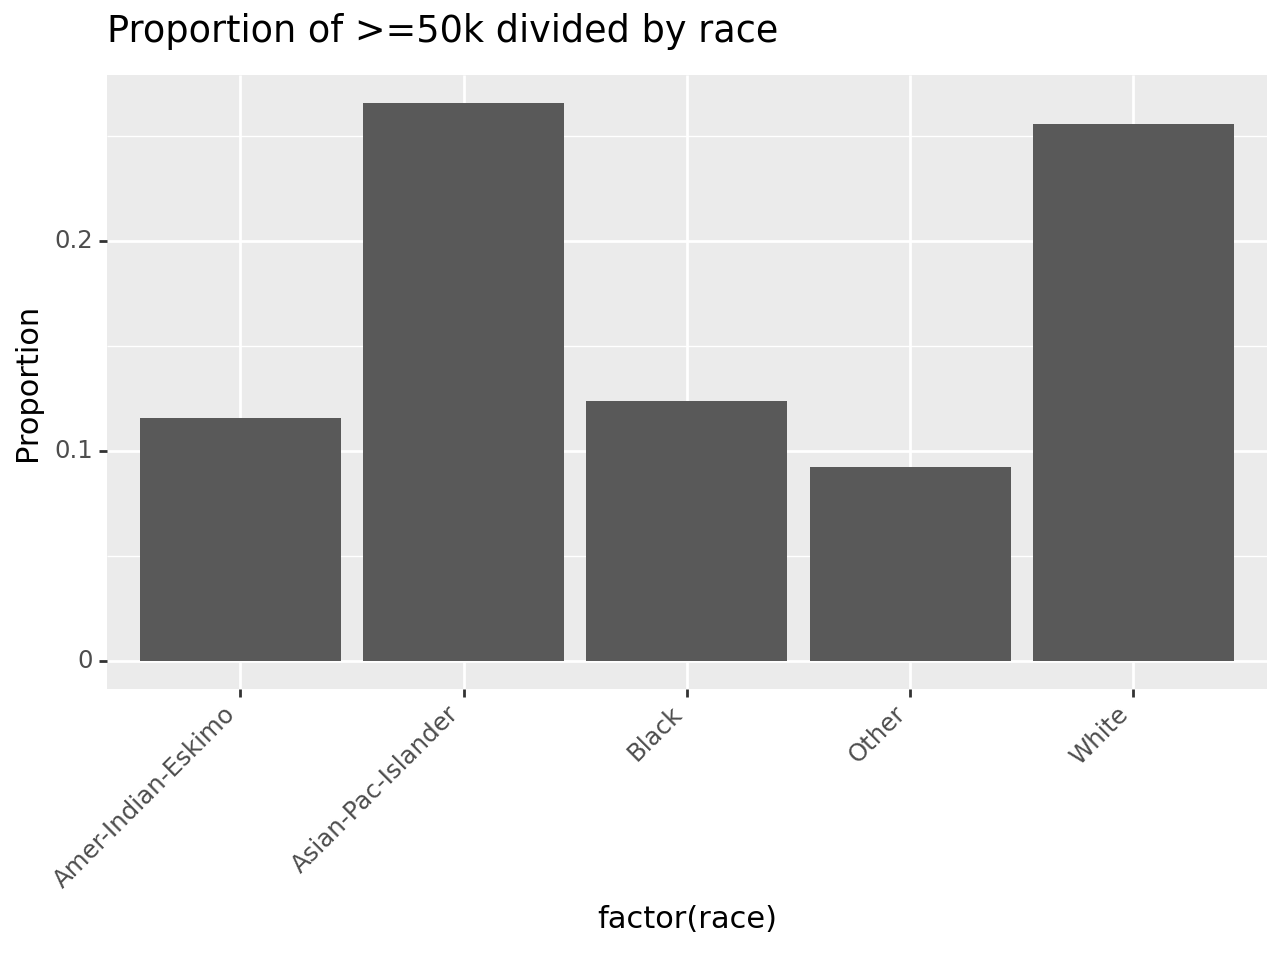

<Figure Size: (640 x 480)>

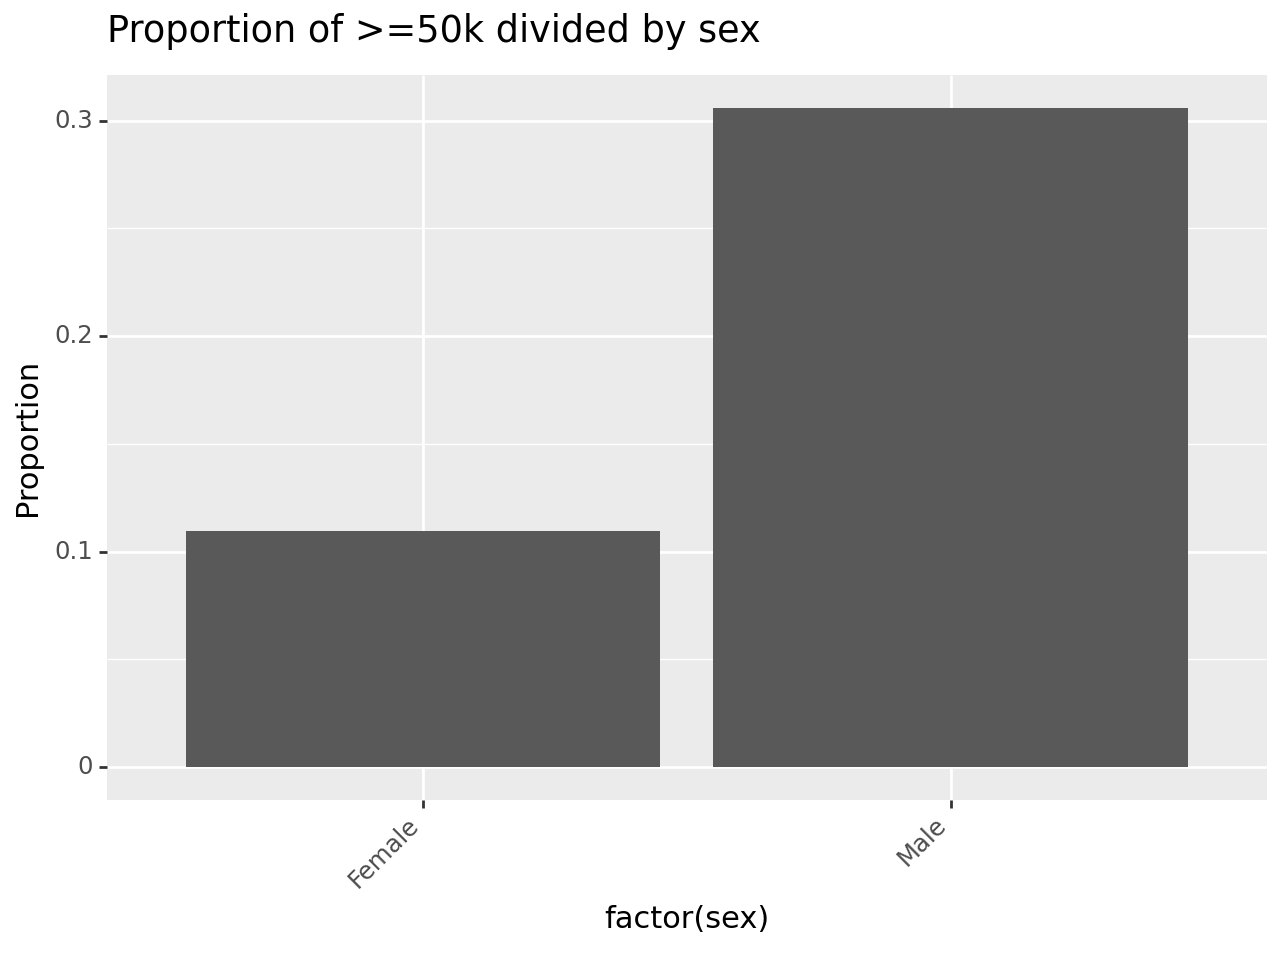

<Figure Size: (640 x 480)>

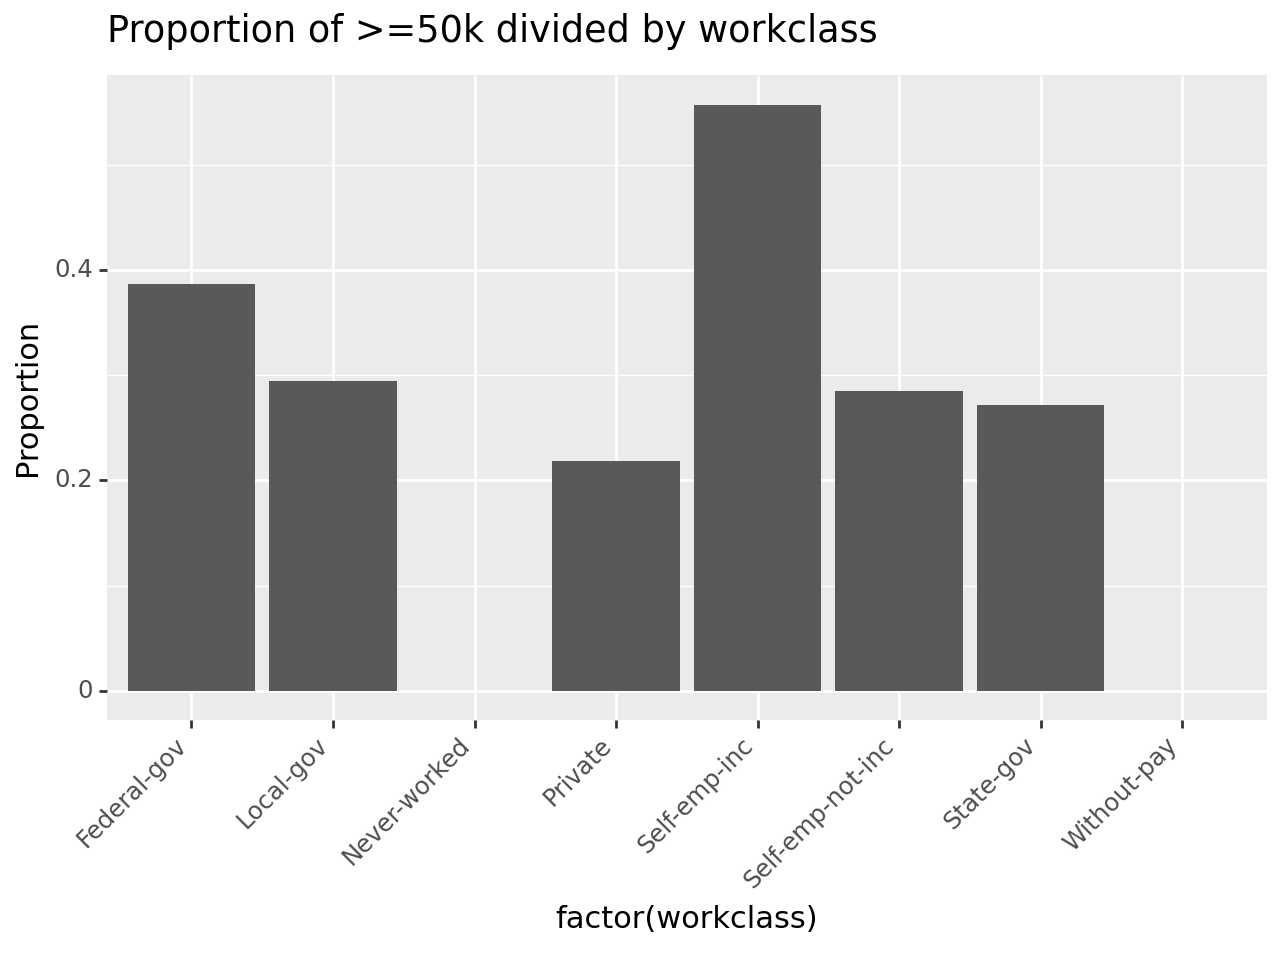

<Figure Size: (640 x 480)>

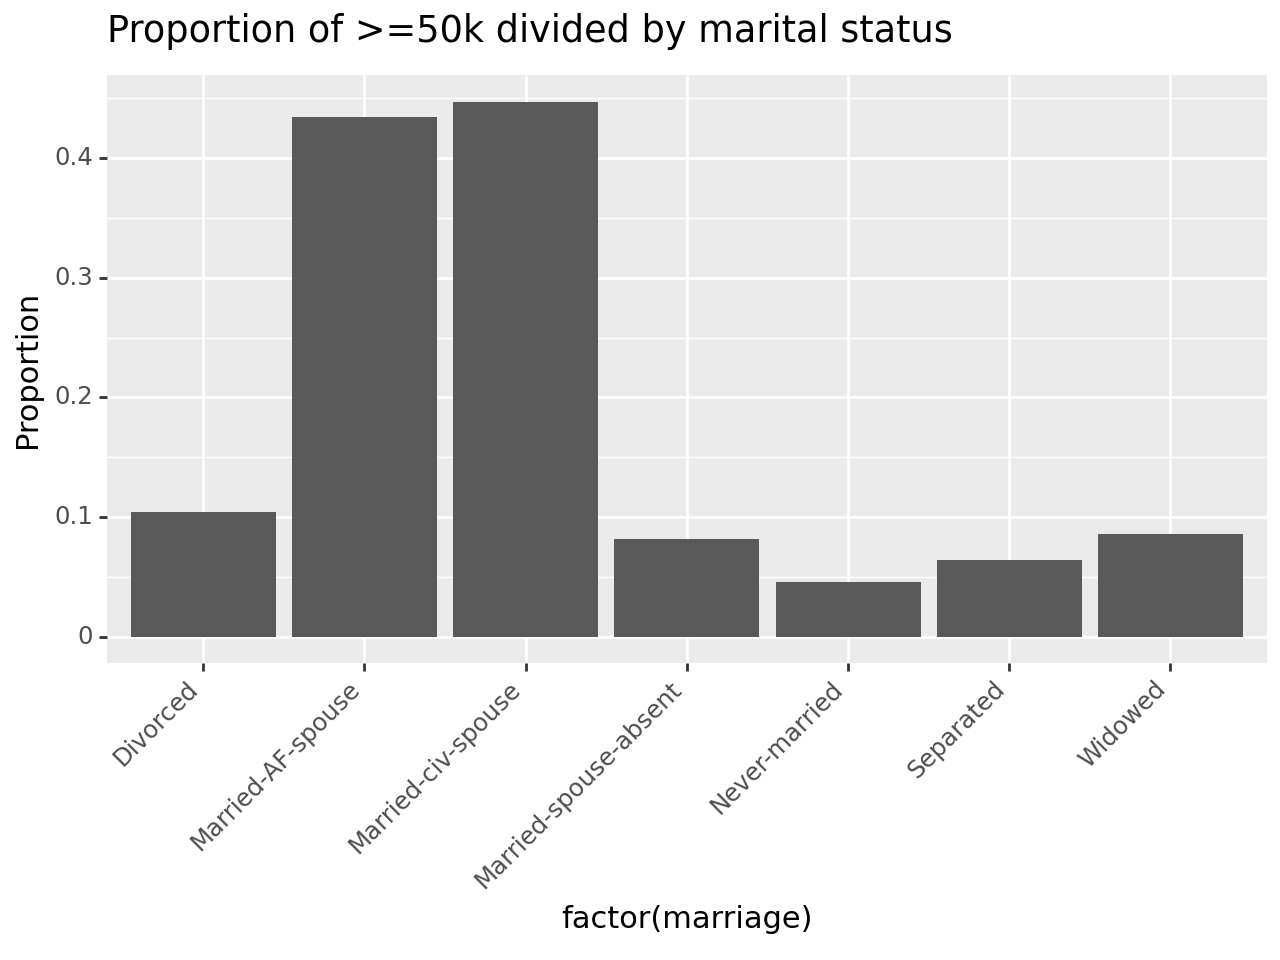

<Figure Size: (640 x 480)>

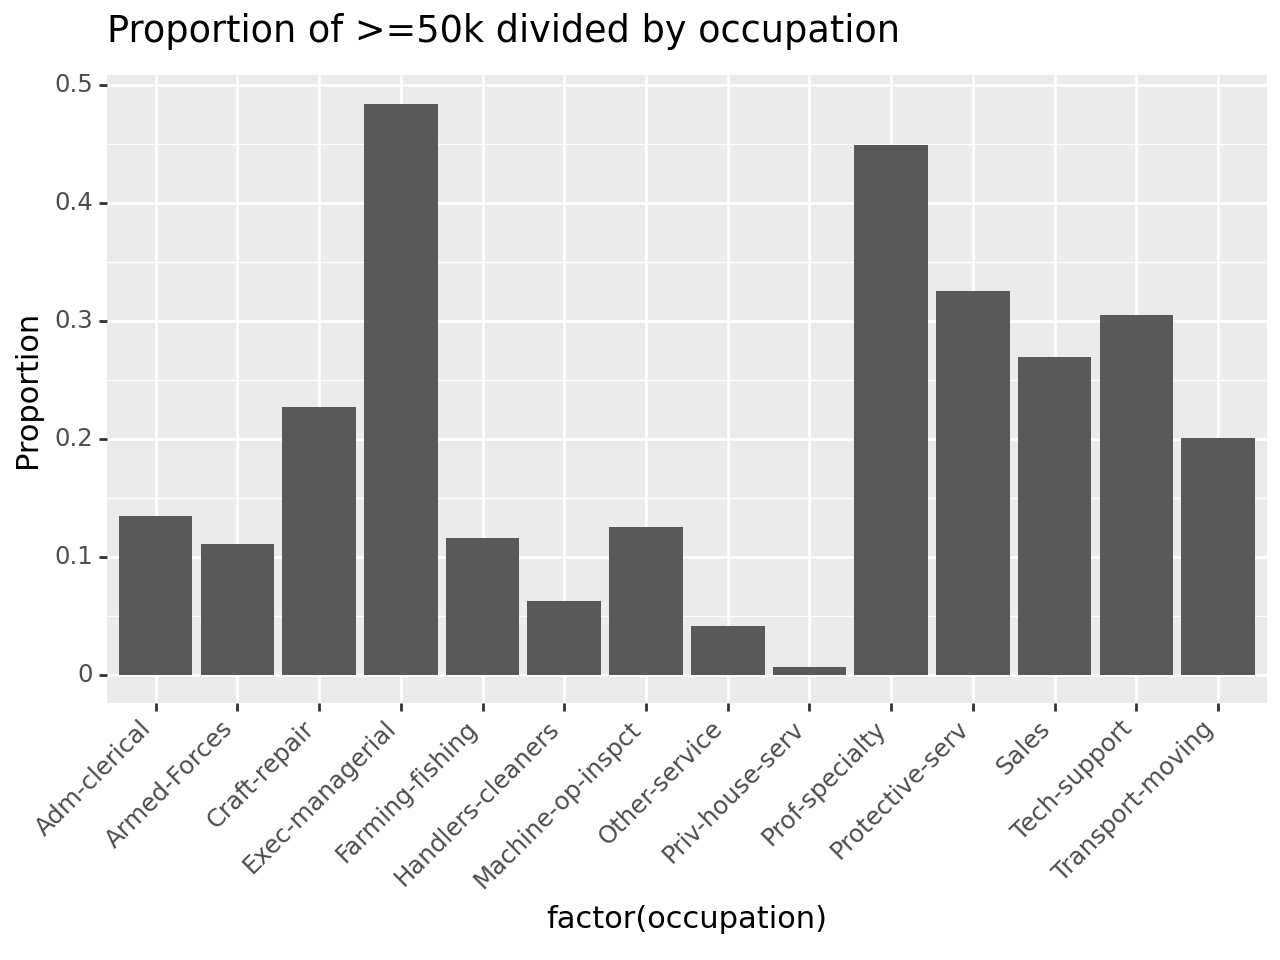

<Figure Size: (640 x 480)>

,sex,race,N_obs,p
0,Female,Amer-Indian-Eskimo,119,0.100840
1,Female,Asian-Pac-Islander,346,0.124277
2,Female,Black,1555,0.057878
3,Female,Other,109,0.055046
4,Female,White,8642,0.118954
5,Male,Amer-Indian-Eskimo,192,0.125000
6,Male,Asian-Pac-Islander,693,0.336219
7,Male,Black,1569,0.189293
8,Male,Other,162,0.117284
9,Male,White,19174,0.317565


In [12]:
(
    ggplot(
    calculate_freq_table(train, ["race"])[1], aes(x='factor(race)', y='p')) + geom_bar(stat='identity', position='dodge')
    + labs(y='Proportion')
    + ggtitle("Proportion of >=50k divided by race")
    + theme(axis_text_x=element_text(rotation=45, hjust=1))
)

(
    ggplot(
    calculate_freq_table(train, ["sex"])[1], aes(x='factor(sex)', y='p')) + geom_bar(stat='identity', position='dodge')
    + labs(y='Proportion')
    + ggtitle("Proportion of >=50k divided by sex")
    + theme(axis_text_x=element_text(rotation=45, hjust=1))
)

(
    ggplot(
    calculate_freq_table(train, ["workclass"])[1], aes(x='factor(workclass)', y='p')) + geom_bar(stat='identity', position='dodge')
    + labs(y='Proportion')
    + ggtitle("Proportion of >=50k divided by workclass")
    + theme(axis_text_x=element_text(rotation=45, hjust=1))
)

(
    ggplot(
    calculate_freq_table(train, ["marital-status"])[1].rename(columns={"marital-status": "marriage"}), aes(x='factor(marriage)', y='p')) + geom_bar(stat='identity', position='dodge')
    + labs(y='Proportion')
    + ggtitle("Proportion of >=50k divided by marital status")
    + theme(axis_text_x=element_text(rotation=45, hjust=1))
)

(
    ggplot(
    calculate_freq_table(train, ["occupation"])[1], aes(x='factor(occupation)', y='p')) + geom_bar(stat='identity', position='dodge')
    + labs(y='Proportion')
    + ggtitle("Proportion of >=50k divided by occupation")
    + theme(axis_text_x=element_text(rotation=45, hjust=1))
)

calculate_freq_table(train, ["sex", "race"])[1]

In [13]:
# Both capital gain and capital loss have many zero values
train.assign(has_gain=train["capital-gain"] > 0).groupby("has_gain").size().reset_index(drop=True)
train.assign(has_loss=train["capital-loss"] > 0).groupby("has_loss").size().reset_index(drop=True)

0    29849
1     2712
dtype: int64

0    31042
1     1519
dtype: int64

In [14]:
print("The train set has {} nulls".format(train.isnull().any(axis=1).sum()))
print("The test set has {} nulls".format(test.isnull().any(axis=1).sum()))

The train set has 2399 nulls
The test set has 1221 nulls


For the purpose of this experiment, we are going to:
1. drop capital gain, capital loss, and fnlwgt
2. drop any row with nulls
3. map all categorical variables to ordinal encodings

In [6]:
def dummify(df, one_hot_encoder):
    vars_to_encode = ['sex', 'race']
    df_to_encode = df[vars_to_encode]
    if not one_hot_encoder:
        one_hot_encoder = OneHotEncoder()
        df_encoded = one_hot_encoder.fit_transform(df_to_encode).toarray()
    else:
        df_encoded = one_hot_encoder.transform(df_to_encode).toarray()
    df_encoded = pd.DataFrame(df_encoded)
    df_encoded.columns = one_hot_encoder.get_feature_names_out()
    # add the encoded columns and drop the original columns
    df = df.drop(vars_to_encode,axis=1)
    df = pd.concat([df, df_encoded], axis=1)
    return df, one_hot_encoder

def preprocess(df):
    df = df.copy()
    df["target"] = df["target"].str.replace(".", "") # the test column has a weird . at the end
    df["target"] = np.where(df["target"]=="<=50K", 0, 1)
    # drop
    df_clean = df.drop(["fnlwgt", "education-num"],axis=1).dropna(axis=0).reset_index(drop=True)
    return df_clean.drop("target",axis=1), df_clean["target"]

def encode_ordinal(df, ordinal_encoder):
    vars_to_encode=["marital-status", "workclass", "relationship", "education", "occupation", "native-country"]
    df_to_encode = df[vars_to_encode]
    if not ordinal_encoder:
        ordinal_encoder = OrdinalEncoder()
        df_encoded = ordinal_encoder.fit_transform(df_to_encode)
    else:
        df_encoded = ordinal_encoder.transform(df_to_encode)
    df_encoded = pd.DataFrame(df_encoded)
    df_encoded.columns = ordinal_encoder.get_feature_names_out()
    # add the encoded columns and drop the original columns
    df = df.drop(vars_to_encode,axis=1)
    df = pd.concat([df, df_encoded], axis=1)
    return df, ordinal_encoder

def scale(df, standard_scaler):
    cols = df.columns
    if not standard_scaler:
        standard_scaler = StandardScaler()
        df = standard_scaler.fit_transform(df)
    else:
        df = standard_scaler.transform(df)
    df = pd.DataFrame(df)
    df.columns = cols
    return df, standard_scaler

def prepare_data(df, one_hot_encoder=None, ordinal_encoder=None, scaler=None):
    df, y = preprocess(df)
    df, ordinal_encoder = encode_ordinal(df, ordinal_encoder)
    df, one_hot_encoder = dummify(df, one_hot_encoder)
    # df, scaler = scale(df, scaler)
    return df, y, one_hot_encoder, ordinal_encoder, scaler

In [7]:
X_train, y_train, one_hot_encoder, ordinal_encoder, scaler = prepare_data(train)
X_test, y_test, _, _, _ = prepare_data(test, one_hot_encoder=one_hot_encoder, ordinal_encoder=ordinal_encoder, scaler=scaler)
X_train
X_test
y_train
y_test

/tmp/ipykernel_52094/2680473418.py:18: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
/tmp/ipykernel_52094/2680473418.py:18: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.


,age,capital-gain,capital-loss,hours-per-week,marital-status,workclass,relationship,education,occupation,native-country,sex_Female,sex_Male,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,race_White
0,39,2174,0,40,4.0,5.0,1.0,9.0,0.0,38.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,50,0,0,13,2.0,4.0,0.0,9.0,3.0,38.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,38,0,0,40,0.0,2.0,1.0,11.0,5.0,38.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,53,0,0,40,2.0,2.0,0.0,1.0,5.0,38.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,28,0,0,40,2.0,2.0,5.0,9.0,9.0,4.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30157,27,0,0,38,2.0,2.0,5.0,7.0,12.0,38.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
30158,40,0,0,40,2.0,2.0,0.0,11.0,6.0,38.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
30159,58,0,0,40,6.0,2.0,4.0,11.0,0.0,38.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
30160,22,0,0,20,4.0,2.0,3.0,11.0,0.0,38.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


,age,capital-gain,capital-loss,hours-per-week,marital-status,workclass,relationship,education,occupation,native-country,sex_Female,sex_Male,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,race_White
0,25,0,0,40,4.0,2.0,3.0,1.0,6.0,38.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,38,0,0,50,2.0,2.0,0.0,11.0,4.0,38.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,28,0,0,40,2.0,1.0,0.0,7.0,10.0,38.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,44,7688,0,40,2.0,2.0,0.0,15.0,6.0,38.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,34,0,0,30,4.0,2.0,1.0,0.0,7.0,38.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15055,33,0,0,40,4.0,2.0,3.0,9.0,9.0,38.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
15056,39,0,0,36,0.0,2.0,1.0,9.0,9.0,38.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
15057,38,0,0,50,2.0,2.0,0.0,9.0,9.0,38.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
15058,44,5455,0,40,0.0,2.0,3.0,9.0,0.0,38.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


0        0
1        0
2        0
3        0
4        0
        ..
30157    0
30158    1
30159    0
30160    0
30161    1
Name: target, Length: 30162, dtype: int64

0        0
1        0
2        1
3        1
4        0
        ..
15055    0
15056    0
15057    0
15058    0
15059    1
Name: target, Length: 15060, dtype: int64

# RF model

We train a simple RF model (no hypertuning) that we will use as a guine-pig to try out different explanation methods

In [23]:
model = RandomForestClassifier(n_estimators=300)
model.fit(X=X_train.values, y=y_train)

y_hat = model.predict(X_test.values)
f1_score(y_true=y_test, y_pred=y_hat)

RandomForestClassifier(n_estimators=300)

0.6622015142690739

In [82]:
ordinal_encoder.categories_

[array(['Divorced', 'Married-AF-spouse', 'Married-civ-spouse',
        'Married-spouse-absent', 'Never-married', 'Separated', 'Widowed'],
       dtype=object),
 array(['Federal-gov', 'Local-gov', 'Private', 'Self-emp-inc',
        'Self-emp-not-inc', 'State-gov', 'Without-pay'], dtype=object),
 array(['Husband', 'Not-in-family', 'Other-relative', 'Own-child',
        'Unmarried', 'Wife'], dtype=object),
 array(['10th', '11th', '12th', '1st-4th', '5th-6th', '7th-8th', '9th',
        'Assoc-acdm', 'Assoc-voc', 'Bachelors', 'Doctorate', 'HS-grad',
        'Masters', 'Preschool', 'Prof-school', 'Some-college'],
       dtype=object),
 array(['Adm-clerical', 'Armed-Forces', 'Craft-repair', 'Exec-managerial',
        'Farming-fishing', 'Handlers-cleaners', 'Machine-op-inspct',
        'Other-service', 'Priv-house-serv', 'Prof-specialty',
        'Protective-serv', 'Sales', 'Tech-support', 'Transport-moving'],
       dtype=object),
 array(['Cambodia', 'Canada', 'China', 'Columbia', 'Cuba',
   

# PDP

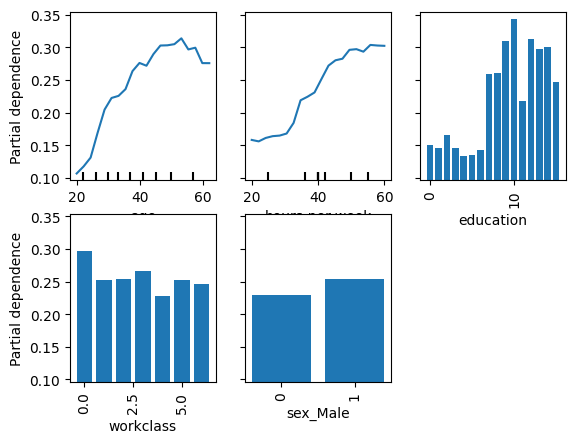

In [86]:
features = ["age", "hours-per-week", "education", "workclass", "sex_Male"]
PartialDependenceDisplay.from_estimator(model, X_train, features, n_jobs=-1, categorical_features=["education", "workclass", "sex_Male"], 
                                        grid_resolution=20)

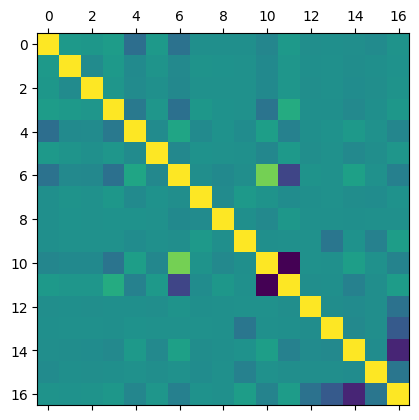

In [92]:
plt.matshow(X_train.corr())
plt.show()

In [121]:
a = train.corr().abs().unstack().sort_values(ascending=False).reset_index()
a.columns = ["v1", "v2", "c"]
a.loc[a.v1 != a.v2]

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


,v1,v2,c
6,hours-per-week,education-num,0.148123
7,education-num,hours-per-week,0.148123
8,education-num,capital-gain,0.122630
9,capital-gain,education-num,0.122630
10,capital-loss,education-num,0.079923
11,education-num,capital-loss,0.079923
12,hours-per-week,capital-gain,0.078409
13,capital-gain,hours-per-week,0.078409
14,age,capital-gain,0.077674
15,capital-gain,age,0.077674


# ALE plots

We will use the alibi library to calculate ALE plots. In this dataset

In [24]:
from alibi.explainers import ALE, plot_ale

In [30]:
X_train.columns

Index(['age', 'capital-gain', 'capital-loss', 'hours-per-week',
       'marital-status', 'workclass', 'relationship', 'education',
       'occupation', 'native-country', 'sex_Female', 'sex_Male',
       'race_Amer-Indian-Eskimo', 'race_Asian-Pac-Islander', 'race_Black',
       'race_Other', 'race_White'],
      dtype='object')

In [45]:
proba_fun = model.predict_proba
proba_ale = ALE(proba_fun, feature_names=X_train.columns.tolist(), target_names=["0", "1"])
proba_exp = proba_ale.explain(X_train.values, features=[0, 1])
proba_exp_2 = proba_ale.explain(X_train.values, features=[3, 5])

array([[<Axes: xlabel='age', ylabel='ALE'>],
       [<Axes: xlabel='capital-gain', ylabel='ALE'>]], dtype=object)

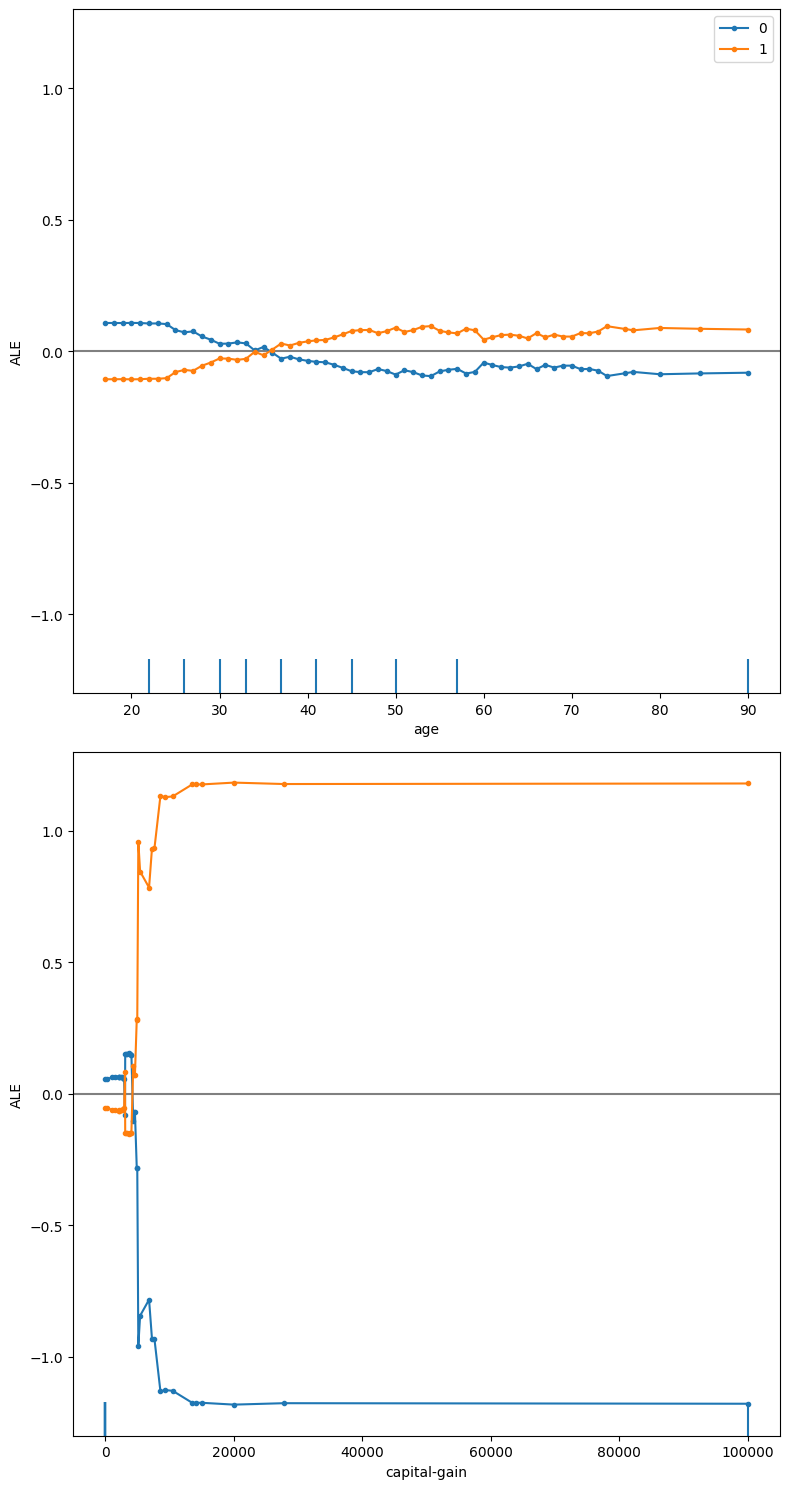

In [46]:
plot_ale(proba_exp, n_cols=1, fig_kw={'figwidth': 8, 'figheight': 15})

array([[<Axes: xlabel='hours-per-week', ylabel='ALE'>],
       [<Axes: xlabel='workclass', ylabel='ALE'>]], dtype=object)

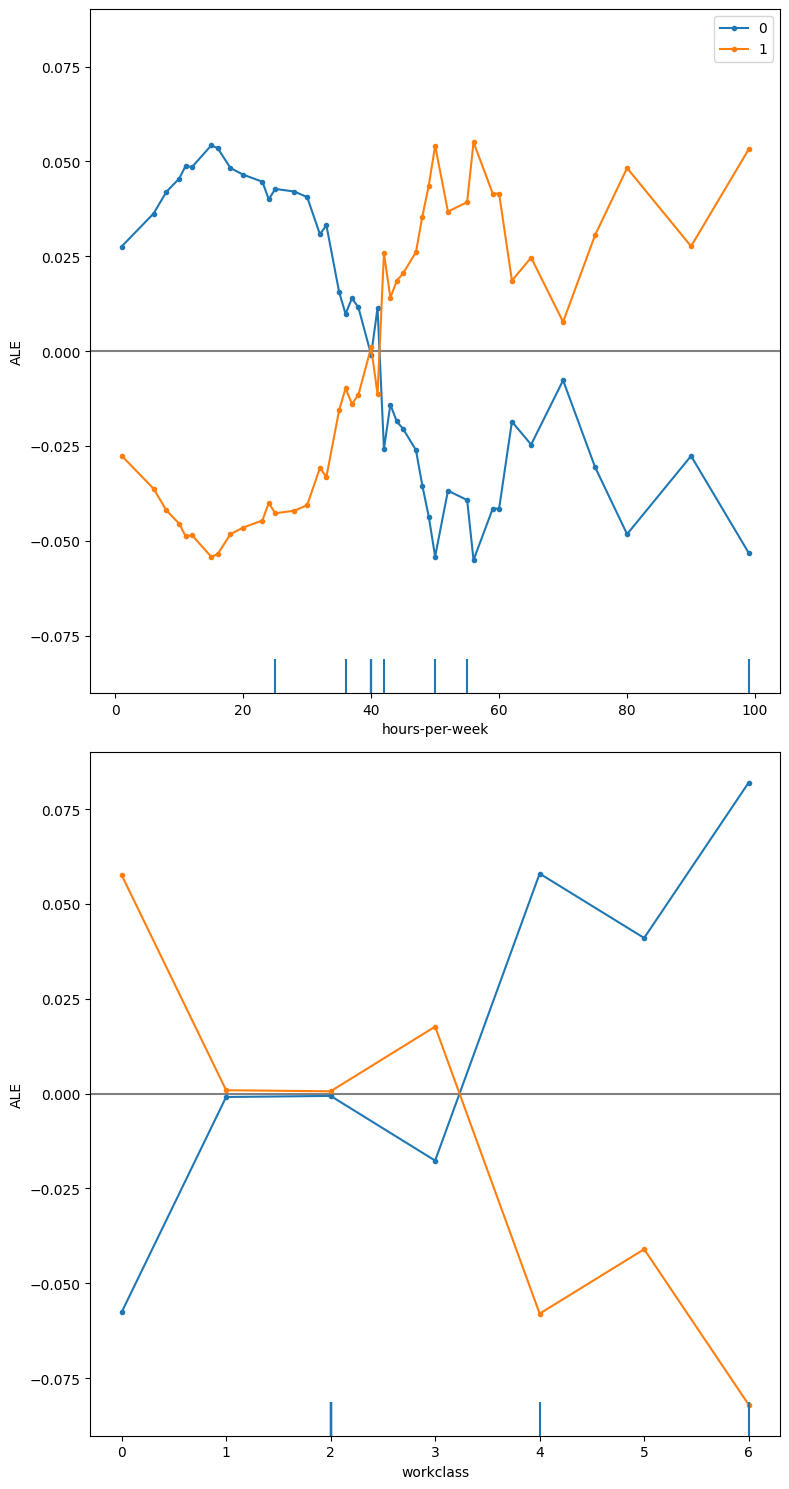

In [47]:
plot_ale(proba_exp_2, n_cols=1, fig_kw={'figwidth': 8, 'figheight': 15})

# Shapley values

The shapley value classification tutorial at https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/tree_based_models/Census%20income%20classification%20with%20LightGBM.html also uses the adult dataset, with a lightGBM model instead of a RF model. This dataset is actually included in the shap library. Let's now see how they processed it, and compare it to how we processed it! and Let's check if the lightgbm model would actually be better than a RF model.

In [59]:
# taken from https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/tree_based_models/Census%20income%20classification%20with%20LightGBM.html 
import lightgbm as lgb
import shap
shap.initjs()

X, y = shap.datasets.adult()
X_display, y_display = shap.datasets.adult(display=True)

# create a train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

We see that they decided to ordinal-encode everything (e.g. Sex, race) rather than dummy coding. They are also keeping education-num rather than the education variable.

In [9]:
# they decided to keep marital status and Sex as ordinal rather than dummy coding them
X 
X_display

,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
0,39.0,7,13.0,4,1,0,4,1,2174.0,0.0,40.0,39
1,50.0,6,13.0,2,4,4,4,1,0.0,0.0,13.0,39
2,38.0,4,9.0,0,6,0,4,1,0.0,0.0,40.0,39
3,53.0,4,7.0,2,6,4,2,1,0.0,0.0,40.0,39
4,28.0,4,13.0,2,10,5,2,0,0.0,0.0,40.0,5
...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27.0,4,12.0,2,13,5,4,0,0.0,0.0,38.0,39
32557,40.0,4,9.0,2,7,4,4,1,0.0,0.0,40.0,39
32558,58.0,4,9.0,6,1,1,4,0,0.0,0.0,40.0,39
32559,22.0,4,9.0,4,1,3,4,1,0.0,0.0,20.0,39


,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
0,39.0,State-gov,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States
1,50.0,Self-emp-not-inc,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States
2,38.0,Private,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States
3,53.0,Private,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States
4,28.0,Private,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba
...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27.0,Private,12.0,Married-civ-spouse,Tech-support,Wife,White,Female,0.0,0.0,38.0,United-States
32557,40.0,Private,9.0,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0.0,0.0,40.0,United-States
32558,58.0,Private,9.0,Widowed,Adm-clerical,Unmarried,White,Female,0.0,0.0,40.0,United-States
32559,22.0,Private,9.0,Never-married,Adm-clerical,Own-child,White,Male,0.0,0.0,20.0,United-States


In [60]:
# let's train the RF model on the shap X_train, y_train, and check performance on the SHAP X_test, y_test

model_rf_shap = RandomForestClassifier()
model_rf_shap.fit(X_train, y_train)
y_hat = model_rf_shap.predict(X_test)
f1_score(y_pred=y_hat, y_true=y_test)

RandomForestClassifier()

0.6736842105263158

The RF model on their preprocessed data is comparable to our result in terms of f1 score (which confirms we didn't make preprocessing mistakes).
Let's check how a lightgbm model would do:

In [23]:
d_train = lgb.Dataset(X_train, label=y_train)
d_test = lgb.Dataset(X_test, label=y_test)

params = {
    "max_bin": 512,
    "learning_rate": 0.05,
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "binary_logloss",
    "num_leaves": 10,
    "verbose": -1,
    "min_data": 100,
    "boost_from_average": True,
    "early_stopping_round": 50,
}

model = lgb.train(
    params,
    d_train,
    10000,
    valid_sets=[d_test],
)

# lightgbm returns probabilities. We threshold them on 0.5 to get classifications

y_hat = model.predict(X_test)
y_hat = np.where(y_hat <= 0.5, 0, 1)
f1_score(y_pred=y_hat, y_true=y_test)

0.7153335661893119

Ah! the lightgbm model does quite a bit better, breaking the 0.7 threshold.
Let's explain this model with shapley.

In [24]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [27]:
X_display.iloc[0,:]

Age                         39.0
Workclass              State-gov
Education-Num               13.0
Marital Status     Never-married
Occupation          Adm-clerical
Relationship       Not-in-family
Race                       White
Sex                         Male
Capital Gain              2174.0
Capital Loss                 0.0
Hours per week              40.0
Country            United-States
Name: 0, dtype: object

In [40]:
shap_values[0]

array([[-4.90548484e-01,  2.75392657e-01, -5.84700009e-01, ...,
         2.49908066e-02,  1.24473086e-01, -1.64659509e-02],
       [-1.00895059e+00,  3.29944730e-01, -7.85310857e-01, ...,
         7.53558627e-02,  1.13838141e+00, -1.50493404e-02],
       [-4.37856520e-01, -1.98391007e-02,  3.08878503e-01, ...,
         2.06305188e-02,  2.67436729e-02, -3.85132536e-03],
       ...,
       [-8.13230626e-01,  2.03190278e-02,  3.91046300e-01, ...,
         3.04790494e-02,  1.54367909e-02, -1.16830782e-02],
       [ 1.89759917e+00,  2.31645411e-02,  2.65437686e-01, ...,
         3.25766309e-02,  1.22408956e+00,  3.59659083e-04],
       [-1.03679176e+00, -2.16312813e-01,  4.57916496e-01, ...,
         2.36833985e-02, -1.14525043e-01, -1.11461339e-02]])

In [47]:
# expected value is the expected value of the model output we compare against. We have two expected values for the two classes
explainer.expected_value
# We have two matrices of SHAP values for the two classes in the shap_values variable (it's a list). Each row of each matrix contains the SHAP values for that observation (for that class)
# summing the SHAP values across a row gives us the total difference between the model output on that row and the expected output
shap_values
# we can now plot for a given row the SHAP values to see the specific influence of the variables on the prediction
shap.force_plot(explainer.expected_value[1], shap_values[1][1, :], X_display.iloc[1, :])
shap.force_plot(explainer.expected_value[1], shap_values[1][100, :], X_display.iloc[100, :])

[2.4326672543732544, -2.4326672543732544]

[array([[-4.90548484e-01,  2.75392657e-01, -5.84700009e-01, ...,
          2.49908066e-02,  1.24473086e-01, -1.64659509e-02],
        [-1.00895059e+00,  3.29944730e-01, -7.85310857e-01, ...,
          7.53558627e-02,  1.13838141e+00, -1.50493404e-02],
        [-4.37856520e-01, -1.98391007e-02,  3.08878503e-01, ...,
          2.06305188e-02,  2.67436729e-02, -3.85132536e-03],
        ...,
        [-8.13230626e-01,  2.03190278e-02,  3.91046300e-01, ...,
          3.04790494e-02,  1.54367909e-02, -1.16830782e-02],
        [ 1.89759917e+00,  2.31645411e-02,  2.65437686e-01, ...,
          3.25766309e-02,  1.22408956e+00,  3.59659083e-04],
        [-1.03679176e+00, -2.16312813e-01,  4.57916496e-01, ...,
          2.36833985e-02, -1.14525043e-01, -1.11461339e-02]]),
 array([[ 4.90548484e-01, -2.75392657e-01,  5.84700009e-01, ...,
         -2.49908066e-02, -1.24473086e-01,  1.64659509e-02],
        [ 1.00895059e+00, -3.29944730e-01,  7.85310857e-01, ...,
         -7.53558627e-02, -1.13838141e

In [48]:
# we can visualise many observations in one go
shap.force_plot(
    explainer.expected_value[1], shap_values[1][:1000, :], X_display.iloc[:1000, :]
)

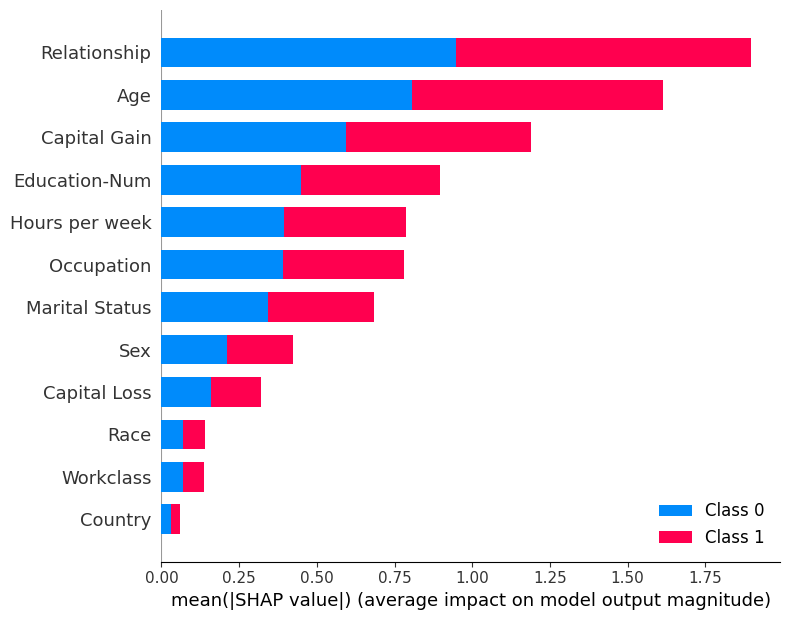

In [49]:
shap.summary_plot(shap_values, X)

# Counterfactuals

In [61]:
import dice_ml
from dice_ml.utils import helpers # helper functions
from sklearn.model_selection import train_test_split

In [62]:
# dice requires the income column for initialization
diceSet = dice_ml.Data(dataframe=X_train.assign(income=y_train), continuous_features=['Age', 'Hours per week'], outcome_name='income')

In [63]:
m = dice_ml.Model(model=model_rf_shap, backend="sklearn")
# Using method=random for generating CFs
exp = dice_ml.Dice(diceSet, m, method="random")

In [72]:
y_test

array([False,  True, False, ..., False, False, False])

In [73]:
y_test
counterfactual_expl = exp.generate_counterfactuals(X_test[1:2], total_CFs=5, desired_class="opposite")
counterfactual_expl.visualize_as_dataframe(show_only_changes=True)

array([False,  True, False, ..., False, False, False])

100%|██████████| 1/1 [00:00<00:00,  6.82it/s]

Query instance (original outcome : True)


,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country,income
0,48.0,1,13.0,0,4,1,4,1,0.0,0.0,58.0,39,True



Diverse Counterfactual set (new outcome: False)


,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country,income
0,-,-,-,-,-,-,-,-,-,-,20.100000381469727,-,False
1,-,-,-,-,12,-,-,-,-,-,31.200000762939453,-,False
2,54.5,-,-,-,-,-,-,0,-,-,-,-,False
3,-,0,-,-,2,-,-,-,-,-,-,-,False
4,-,-,6.0,-,-,-,-,-,-,1816.0,-,-,False


In [75]:
# we can use counterfactuals to summarize local feature importance
query_instance = X_test[1:2]
imp = exp.local_feature_importance(query_instance, total_CFs=20)
print(imp.local_importance)

100%|██████████| 1/1 [00:00<00:00,  3.78it/s]

[{'Age': 0.35, 'Education-Num': 0.2, 'Occupation': 0.2, 'Workclass': 0.15, 'Relationship': 0.15, 'Capital Gain': 0.15, 'Marital Status': 0.1, 'Race': 0.1, 'Country': 0.1, 'Sex': 0.05, 'Hours per week': 0.05, 'Capital Loss': 0.0}]


In [77]:
# and we can aggregate over multiple instances to obtain global explanations
query_instances = X_test[0:100]
imp = exp.global_feature_importance(query_instances)
print(imp.summary_importance)

100%|██████████| 100/100 [00:16<00:00,  6.05it/s]


{'Capital Gain': 0.606, 'Capital Loss': 0.196, 'Education-Num': 0.12, 'Age': 0.12, 'Occupation': 0.095, 'Hours per week': 0.094, 'Relationship': 0.084, 'Workclass': 0.074, 'Country': 0.074, 'Marital Status': 0.072, 'Race': 0.065, 'Sex': 0.032}
